# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import spacy

import torch
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from torch.utils import data

from typing import List, Tuple
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer

In [2]:
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(42)

In [3]:
torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=1)

In [4]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Imdb Sentiment Dataset

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

emb_a = embedder.encode(["A wonderful movie"])
emb_b = embedder.encode(["The film was amazing"])

cosine_similarity(emb_a, emb_b)

array([[0.6546832]], dtype=float32)

In [6]:
imdb_df = pd.read_pickle("../../dataset/imdb/IMDB_Dataset.pkl").drop(columns=["sentence_emb"])

with pd.option_context("display.max_colwidth", 400):
    display(imdb_df.head(5))

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regard...",1
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the ref...",1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof...",1
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Paren...",0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action t...",1


We clean the sentences and get their embeddings

In [7]:
cached_stopwords = stopwords.words("english")
nlp = spacy.load("en_core_web_sm")

def clean_text(text: str) -> str:

    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in cached_stopwords])
    text = re.sub("<br /><br />", "", text)
    text = re.sub("\\t", "", text)
    sentences = text.split(".")
    sentences_clean = [el for el in sentences if el != '']

    return sentences_clean

def encode_sentences(sentences: List) -> np.ndarray:
    return np.array([embedder.encode(sentence) for sentence in sentences]).squeeze()

In [8]:
trial = True
if trial:
    imdb_df = imdb_df[:10000]
    
if "sentence_emb" not in imdb_df.columns:
    clean_features = imdb_df["review"].map(clean_text)
    encoded_features = clean_features.map(encode_sentences)

    imdb_df.insert(2, "sentence_emb", encoded_features)
    #imdb_df.to_pickle("../../dataset/imdb/IMDB_Dataset.pkl")

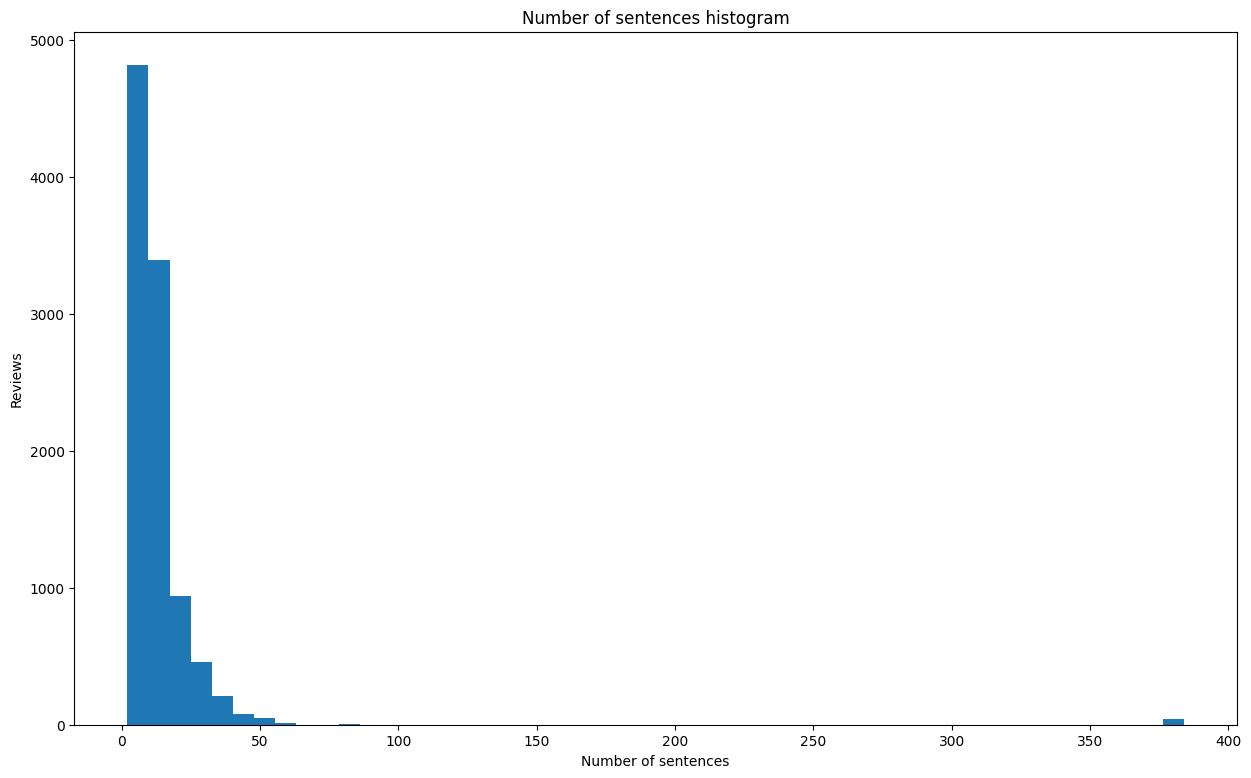

In [ ]:
sentence_counts = imdb_df["sentence_emb"].apply(lambda x: len(x)).values

plt.figure(figsize=(15,9))
plt.title("Number of sentences histogram")
plt.xlabel("Number of sentences")
plt.ylabel("Reviews")
plt.hist(sentence_counts, bins=50)
plt.show()

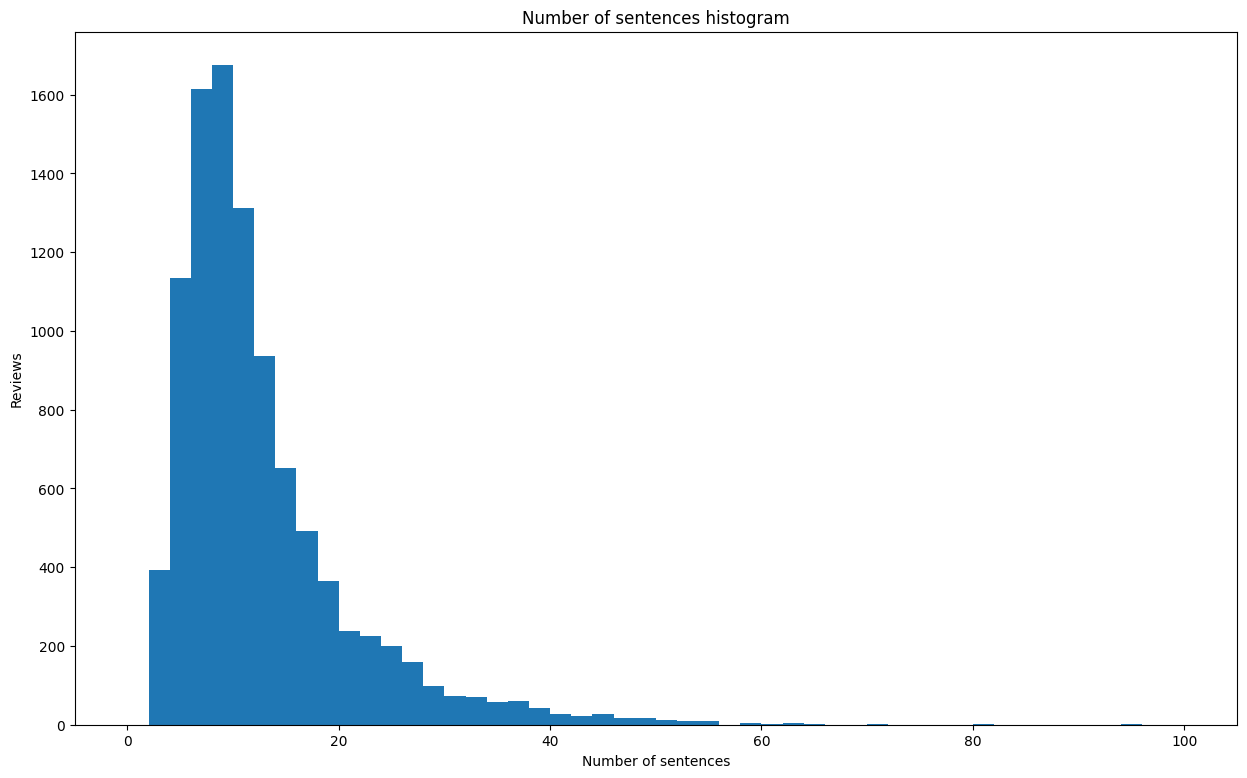

In [ ]:
plt.figure(figsize=(15,9))
plt.title("Number of sentences histogram")
plt.xlabel("Number of sentences")
plt.ylabel("Reviews")
plt.hist(sentence_counts, bins=50, range=(0, 100))
plt.show()

We remove outliers in order to have more balanced padded sequences

In [ ]:
MAX_SENTENCES = 40

imdb_df = imdb_df[imdb_df["sentence_emb"].apply(lambda x: len(x)) <= MAX_SENTENCES]
imdb_df = imdb_df.reset_index(drop=True)

In [ ]:
imdb_df

,review,sentiment,sentence_emb
0,One of the other reviewers has mentioned that ...,1,"[[0.0028965054, -0.00521643, 0.008160139, 0.08..."
1,A wonderful little production. <br /><br />The...,1,"[[-0.022689639, 0.03716715, 0.0022187403, -0.0..."
2,I thought this was a wonderful way to spend ti...,1,"[[0.0136362305, -0.07501455, 0.026115745, 0.05..."
3,Basically there's a family where a little boy ...,0,"[[-0.06623291, 0.03892335, -0.04048848, -0.028..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[[-0.07374094, 0.03781967, 0.010404704, -0.078..."
...,...,...,...
9813,"Fun, entertaining movie about WWII German spy ...",1,"[[-0.026361026, -0.078349315, -0.07601496, 0.0..."
9814,Give me a break. How can anyone say that this ...,0,"[[-0.091661416, 0.011880031, 0.06739228, -0.00..."
9815,This movie is a bad movie. But after watching ...,0,"[[-0.050063267, 0.014444304, -0.04015872, 0.04..."
9816,This is a movie that was probably made to ente...,0,"[[-0.07030647, 0.05444126, 0.0039178566, -0.02..."


# Torch dataset preprocessing

In [ ]:
class IMDB_Dataset(data.Dataset):
	def __init__(self, data_df: pd.DataFrame):
		super().__init__()
		#x = data_df.sentence_emb.apply(lambda x: np.mean(x, axis=0)).values
		x = data_df.sentence_emb.values
		y = data_df.sentiment.values
		self.x_train = list(map(lambda x: torch.tensor(x), x))
		self.y_train = list(map(lambda y: torch.tensor(y), y))

	def __len__(self):
		return len(self.y_train)

	def __getitem__(self, idx: int):
		return self.x_train[idx], self.y_train[idx]

In [ ]:
def collate_fn(data: List[Tuple[torch.Tensor, torch.Tensor]]):

    data.sort(key=lambda x: x[0].shape[0], reverse=True)
    sequences, label = zip(*data)
    lengths = [len(seq) for seq in sequences]
    padded_seq = pad_sequence(sequences, batch_first=True, padding_value=0)
    
    return padded_seq, torch.from_numpy(np.array(lengths)), torch.from_numpy(np.array(label))

In [ ]:
split = 0.8

imdb_df_train = imdb_df[:int(0.8 * len(imdb_df))]
imdb_df_val = imdb_df[int(0.8 * len(imdb_df)):]

In [ ]:
BATCH_SIZE = 64

train_data = IMDB_Dataset(imdb_df_train)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=collate_fn)

val_data = IMDB_Dataset(imdb_df_val)
val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, collate_fn=collate_fn)

In [ ]:
BATCH_SIZE = 64

train_data = IMDB_Dataset(imdb_df_train)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True,) #collate_fn=collate_fn, )

val_data = IMDB_Dataset(imdb_df_val)
val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True,) #collate_fn=collate_fn, )

# Model

In [132]:
class LSTM_Classifier(nn.Module):

    def __init__(self, emb_size: int, hidden_size: int = 16, num_layers: int = 2, bidirectional: bool = False) -> None:
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0.1,
        )

        self.dense = nn.Linear(hidden_size, 128)
        #It will change to regressor
        self.dropout = nn.Dropout(0.1)
        self.smaller_dense = nn.Linear(128, 16)
        self.classifier = nn.Linear(16, 1)
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        
        batch_size = x.size(0)
        
        lstm_out, hidden_state = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        out = self.dense(lstm_out)
        out = self.dropout(out)
        out = self.smaller_dense(out)
        out = self.classifier(out)
        out = self.tanh(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden_state

    def init_hidden(self, batch_size):

        hidden = (torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
                  torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda())
        
        return hidden

In [91]:
class SimpleModel(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.dense = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.1)
        self.dense2 = nn.Linear(768, 128)
        self.dense3 = nn.Linear(128, 32)
        self.classifier = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        out = self.dense(x)
        out = self.dropout(out)
        out = self.dense2(out)
        out = self.dropout(out)
        out = self.dense3(out)
        out = self.sigmoid(self.classifier(out))

        return out

In [92]:
simple_model = SimpleModel()
print(simple_model)

SimpleModel(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (dense2): Linear(in_features=768, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [133]:
EMBEDDING_DIM = train_data.__getitem__(0)[0][0].shape[0]
NUM_LAYERS = 10
HIDDEN_DIM = 256

model = LSTM_Classifier(emb_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM, num_layers=NUM_LAYERS)
print(model)

LSTM_Classifier(
  (lstm): LSTM(384, 256, num_layers=10, batch_first=True, dropout=0.1)
  (dense): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (smaller_dense): Linear(in_features=128, out_features=16, bias=True)
  (classifier): Linear(in_features=16, out_features=1, bias=True)
  (tanh): Tanh()
)


# Training

In [107]:
EPOCHS = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=1e-3)

simple_model.cuda()
simple_model.train()

cnt = 0

train_loss = []
val_loss = []

train_accuracy = []
val_accuracy = []

for epoch in range(EPOCHS):

    for embeddings, labels in train_loader:
        cnt += 1

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        simple_model.zero_grad()

        output = simple_model(embeddings)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        train_acc = torch.sum(output.squeeze() == labels.float()) / labels.shape[0]

        nn.utils.clip_grad_norm_(simple_model.parameters(), max_norm=5)
        optimizer.step()

        if cnt % 100 == 0:
            val_losses = []
            val_accs = []
            simple_model.eval()
            for embeddings, labels in val_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history

                embeddings, labels = embeddings.cuda(), labels.cuda()  
                output = simple_model(embeddings)
                v_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(v_loss.item())
                
                val_acc = torch.sum(output.squeeze() == labels.float()) / labels.shape[0]
                val_accs.append(val_acc.cpu())

            simple_model.train()
            print(
                "Epoch: {}/{}...".format(epoch+1, EPOCHS),
                "Loss: {:.6f}...".format(loss.item()),
                "Val Loss: {:.6f}".format(np.mean(val_losses)),
                "Accuracy: {:.6f}".format(train_acc),
                "Val accuracy: {:.6f}".format(val_acc),
            )

    train_loss.append(round(loss.item(), 2))
    val_loss.append(np.mean(val_losses))
    
    train_accuracy.append(round(train_acc.item(), 2))
    val_accuracy.append(np.mean(val_accs))

Epoch: 1/10... Loss: 174.673096... Val Loss: 133.437627 Accuracy: 0.656250 Val accuracy: 0.484375
Epoch: 1/10... Loss: 149.719788... Val Loss: 133.437627 Accuracy: 0.562500 Val accuracy: 0.484375
Epoch: 1/10... Loss: 128.925385... Val Loss: 133.437627 Accuracy: 0.484375 Val accuracy: 0.484375
Epoch: 1/10... Loss: 137.243134... Val Loss: 133.437627 Accuracy: 0.515625 Val accuracy: 0.484375
Epoch: 1/10... Loss: 133.084259... Val Loss: 133.437627 Accuracy: 0.500000 Val accuracy: 0.484375
Epoch: 1/10... Loss: 149.719788... Val Loss: 133.437627 Accuracy: 0.562500 Val accuracy: 0.484375
Epoch: 2/10... Loss: 128.925369... Val Loss: 133.437627 Accuracy: 0.484375 Val accuracy: 0.484375
Epoch: 2/10... Loss: 124.766495... Val Loss: 133.437627 Accuracy: 0.468750 Val accuracy: 0.484375
Epoch: 2/10... Loss: 145.560913... Val Loss: 133.437627 Accuracy: 0.546875 Val accuracy: 0.484375
Epoch: 2/10... Loss: 116.448730... Val Loss: 133.437627 Accuracy: 0.437500 Val accuracy: 0.484375
Epoch: 2/10... Loss:

In [136]:
EPOCHS = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

model.cuda()
model.train()

cnt = 0

train_loss = []
val_loss = []

train_accuracy = []
val_accuracy = []

for epoch in range(EPOCHS):
    hidden_state = model.init_hidden(batch_size=BATCH_SIZE)

    for embeddings, _, labels in train_loader:
        cnt += 1

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        hidden_state = tuple([each.data for each in hidden_state])

        model.zero_grad()

        output, hidden_state = model(embeddings, hidden_state)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        train_acc = torch.sum(output.squeeze() == labels.float()) / labels.shape[0]

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        if cnt % 100 == 0:
            val_h = model.init_hidden(BATCH_SIZE)
            val_losses = []
            val_accs = []
            model.eval()
            for embeddings, _, labels in val_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history

                embeddings, labels = embeddings.cuda(), labels.cuda()  
                output, val_h = model(embeddings, val_h)
                v_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(v_loss.item())
                
                val_acc = torch.sum(output.squeeze() == labels.float()) / labels.shape[0]
                val_accs.append(val_acc.cpu())

            model.train()
            print(
                "Epoch: {}/{}...".format(epoch+1, EPOCHS),
                "Loss: {:.6f}...".format(loss.item()),
                "Val Loss: {:.6f}".format(np.mean(val_losses)),
                "Accuracy: {:.6f}".format(train_acc),
                "Val accuracy: {:.6f}".format(val_acc),
            )

    train_loss.append(round(loss.item(), 2))
    val_loss.append(np.mean(val_losses))
    
    train_accuracy.append(round(train_acc.item(), 2))
    val_accuracy.append(np.mean(val_accs))

Epoch: 1/10... Loss: 174.673096... Val Loss: 137.243141 Accuracy: 0.593750 Val accuracy: 0.578125
Epoch: 2/10... Loss: 133.084259... Val Loss: 137.243141 Accuracy: 0.468750 Val accuracy: 0.578125
Epoch: 3/10... Loss: 133.084259... Val Loss: 137.243141 Accuracy: 0.359375 Val accuracy: 0.578125
Epoch: 4/10... Loss: 141.402023... Val Loss: 137.243141 Accuracy: 0.343750 Val accuracy: 0.578125
Epoch: 5/10... Loss: 128.925385... Val Loss: 137.243141 Accuracy: 0.375000 Val accuracy: 0.578125
Epoch: 5/10... Loss: 162.196442... Val Loss: 137.243141 Accuracy: 0.546875 Val accuracy: 0.578125
Epoch: 6/10... Loss: 162.196442... Val Loss: 137.243141 Accuracy: 0.593750 Val accuracy: 0.578125
Epoch: 7/10... Loss: 112.289841... Val Loss: 137.243141 Accuracy: 0.390625 Val accuracy: 0.578125
Epoch: 8/10... Loss: 149.719788... Val Loss: 137.243141 Accuracy: 0.500000 Val accuracy: 0.578125
Epoch: 9/10... Loss: 108.130959... Val Loss: 137.243141 Accuracy: 0.359375 Val accuracy: 0.578125
Epoch: 10/10... Loss

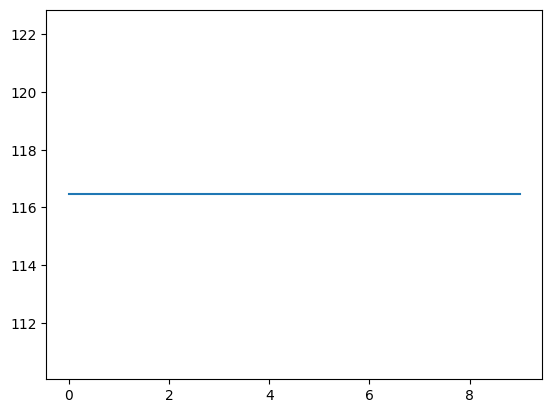

In [137]:
plt.plot(train_loss)
plt.show()

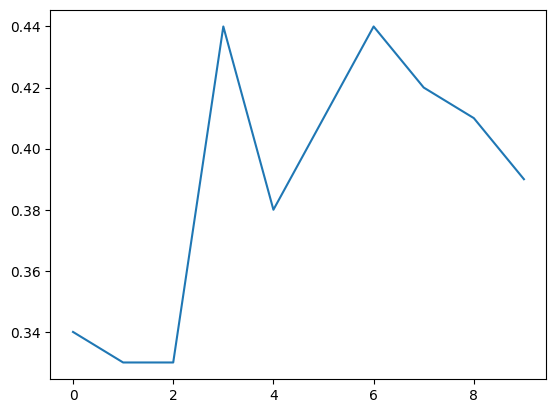

In [138]:
plt.plot(train_accuracy)
plt.show()